<a href="https://colab.research.google.com/github/laihowo/HK_Carpark_Vacancy/blob/main/Benny_EDA_Raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import os
vacancy_path = 'vacancy_all'
vacancy_id = '1O2T7bpJKwtC8UT1AG4QQQj8vRxUFEjKn'
if not os.path.exists(vacancy_path):
  !gdown $vacancy_id -O $vacancy_path
  !unzip -q $vacancy_path

In [ ]:
import json
import requests
info_url = 'https://resource.data.one.gov.hk/td/carpark/basic_info_all.json'
info_json = json.loads(requests.get(info_url).content)
info_df = pd.json_normalize(info_json['car_park'])

In [ ]:
# @title District Input { run: "auto", vertical-output: true }
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display

# List Item
district_list = info_df['district_en'].unique()
district_list = sorted(np.delete(district_list, -1))

# Create a Dropdown widget
district_picker = widgets.Dropdown(options=district_list)

# Display the widget
display(district_picker)

Dropdown(options=('Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing', 'Kwun Tong', 'North…

In [ ]:
# @title Park Input { run: "auto", vertical-output: true }

# List Item
district_df = info_df[info_df['district_en'] == district_picker.value]
park_list = sorted(district_df['name_en'].unique())

# Create a SelectMultiple widget
park_multi_select = widgets.SelectMultiple(
    options=park_list,
    description='Car Parks:',
    rows=len(park_list),
    layout=Layout(width='100%')
)

# Display the widget
display(park_multi_select)

SelectMultiple(description='Car Parks:', layout=Layout(width='100%'), options=('Hong Kong Tennis Centre', 'Hop…

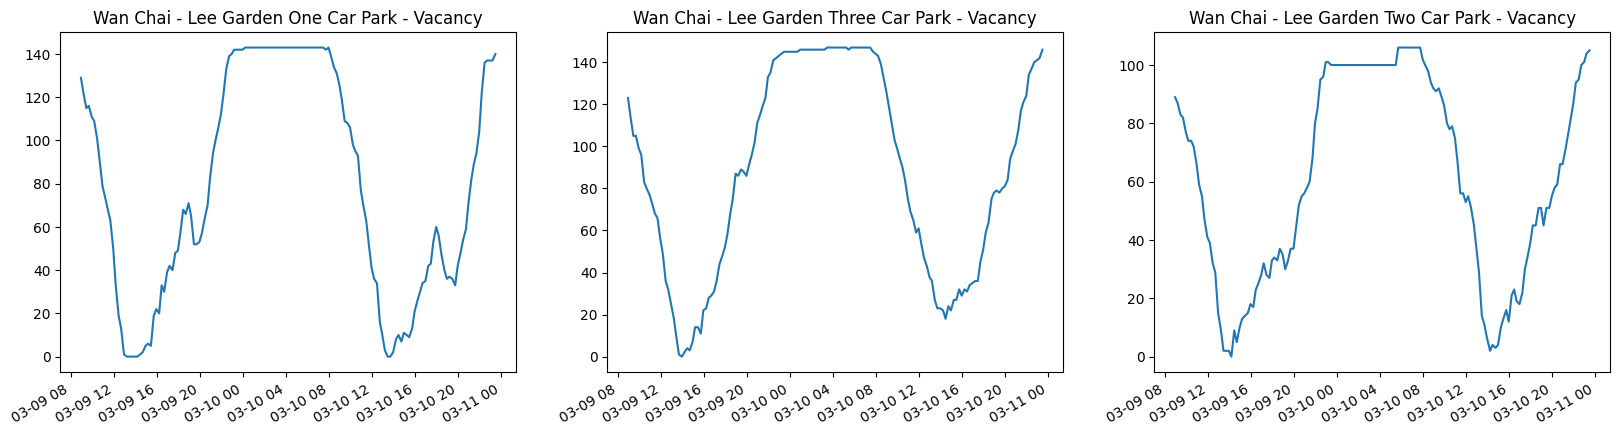

In [ ]:
import warnings
warnings.filterwarnings('ignore')

vacancy_path = 'vacancy_all.csv'
park_df_list = []
for item in park_multi_select.value:
  park_df = pd.DataFrame()
  park_id_input = info_df.loc[info_df['name_en'] == item, 'park_id'].iloc[0]

  for file in sorted(os.listdir(vacancy_path)):
    if file == '20210310-2345.csv':
      break

    vacancy_df = pd.read_csv(vacancy_path + '/' + file)
    vacancy_condition = (vacancy_df['vacancy_type'] == 'A') & (vacancy_df['vehicle_type.type'] == 'P') & (vacancy_df['park_id'] == park_id_input)
    v_df = vacancy_df[vacancy_condition]
    v_df['lastupdate'] = pd.to_datetime(v_df['lastupdate'])
    park_df = pd.concat([park_df, v_df[['lastupdate', 'park_id', 'vacancy']]])

  park_df.set_index('lastupdate', inplace=True)
  park_df = park_df.sort_values(by='lastupdate')
  park_df_list.append(park_df)

fig = plt.figure(figsize=(20, 5))
MAX_SUBPLOT = 3
for index, df in enumerate(park_df_list, start=1):
  if len(df) == 0:
    continue
  if index > MAX_SUBPLOT:
    break

  plt_sub = fig.add_subplot(1, MAX_SUBPLOT, index)
  plt_sub.plot(df['vacancy'])

  park_id = df['park_id'].iloc[0]
  park_name = info_df.loc[info_df['park_id'] == park_id, 'name_en'].iloc[0]
  plt.title(' - '.join([district_picker.value, park_name, 'Vacancy']))

fig.autofmt_xdate()
plt.show()